In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize
from IPython.display import clear_output
import numpy as np
import os


/home/user/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
pip list

Package                       Version
----------------------------- ----------------
alabaster                     0.7.16
anyio                         4.4.0
appdirs                       1.4.4
argon2-cffi                   21.1.0
arrow                         1.3.0
asgiref                       3.8.1
asttokens                     2.4.1
async-lru                     2.0.4
attrs                         23.2.0
Babel                         2.15.0
backcall                      0.2.0
beautifulsoup4                4.10.0
beniget                       0.4.1
bleach                        4.1.0
blinker                       1.4
bootstrap-py                  2.0.0
Brlapi                        0.8.3
Brotli                        1.0.9
certifi                       2020.6.20
chardet                       4.0.0
charset-normalizer            3.3.2
click                         8.0.3
colorama                      0.4.4
comm                          0.2.2
command-not-found             0.3
contourpy 

In [3]:
# Установка параметров
input_size = 784  # 28x28
hidden_size1 = 500
hidden_size2 = 250
num_classes = 10
num_epochs =200
batch_size = 100
learning_rate = 0.01
save_model = True
log_file_path = 'results/ResultsLog.log'

In [4]:
# Загрузка и нормализация данных MNIST
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Определение модели
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_size2, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        
        out = self.fc3(out)
        return out

In [6]:
model = NeuralNet(input_size, hidden_size1, hidden_size2, num_classes)

# Инициализация функций потерь
criterion_ce = nn.CrossEntropyLoss()
criterion_mse = nn.MSELoss()
criterion_l1 = nn.L1Loss()
criterion_nll = nn.NLLLoss()
criterion_bce = nn.BCELoss()
criterion_bce_with_logits = nn.BCEWithLogitsLoss()
criterion_soft_margin = nn.SoftMarginLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:

# Инициализация для графиков
loss_ce_list = {'train': [], 'val': []}
accuracy_list = {'train': [], 'val': []}
precision_list = {'train': [], 'val': []}
recall_list = {'train': [], 'val': []}
f1_list = {'train': [], 'val': []}
roc_auc_list = {'train': [], 'val': []}

In [8]:
# Проверка существования файла логирования и создание нового
if not os.path.exists(log_file_path):
    with open(log_file_path, 'w') as log_file:
        log_file.write("Test No\tAccuracy\tPrecision\tRecall\tF1-score\tROC AUC\n")


In [9]:

# Функция для вычисления метрик
def compute_metrics(loader, model):
    all_labels = []
    all_predicted = []
    all_probs = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_predicted.extend(predicted.numpy())
            all_probs.extend(outputs.numpy())
    
    accuracy = accuracy_score(all_labels, all_predicted)
    precision = precision_score(all_labels, all_predicted, average='micro')
    recall = recall_score(all_labels, all_predicted, average='micro')
    f1 = f1_score(all_labels, all_predicted, average='micro')
    roc_auc = roc_auc_score(label_binarize(all_labels, classes=np.arange(num_classes)), all_probs, average='micro')
    
    return accuracy, precision, recall, f1, roc_auc

In [10]:
# Функция для обновления и сохранения графиков
def update_plots(loss_ce_list, accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, epoch, save_path='../temp/training_progress.png'):
    clear_output(wait=True)
    plt.figure(figsize=(18, 18))
    
    # График функции потерь CrossEntropy
    plt.subplot(3, 2, 1)
    plt.plot(loss_ce_list['train'], label='Train CrossEntropy Loss')
    plt.plot(loss_ce_list['val'], label='Validation CrossEntropy Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('CrossEntropy Loss')
    plt.legend()
    
    # График точности
    plt.subplot(3, 2, 2)
    plt.plot(accuracy_list['train'], label='Train Accuracy')
    plt.plot(accuracy_list['val'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    # График Precision
    plt.subplot(3, 2, 3)
    plt.plot(precision_list['train'], label='Train Precision')
    plt.plot(precision_list['val'], label='Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.legend()

    # График Recall
    plt.subplot(3, 2, 4)
    plt.plot(recall_list['train'], label='Train Recall')
    plt.plot(recall_list['val'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.legend()

    # График F1-score
    plt.subplot(3, 2, 5)
    plt.plot(f1_list['train'], label='Train F1-score')
    plt.plot(f1_list['val'], label='Validation F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.title('F1-score')
    plt.legend()

    # График ROC AUC
    plt.subplot(3, 2, 6)
    plt.plot(roc_auc_list['train'], label='Train ROC AUC')
    plt.plot(roc_auc_list['val'], label='Validation ROC AUC')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title('ROC AUC')
    plt.legend()
    
    # Номер теста
    plt.figtext(0.5, 0.05, f'Test No: {get_test_number(log_file_path)}', wrap=True, horizontalalignment='center', fontsize=12)

    # Добавление информации о модели
    plt.suptitle(f'Loss Function: CE Optimizer: SGD, LR: {learning_rate}, Epochs: {num_epochs}, Batch Size: {batch_size}')
    
    # Информация о слоях модели
    model_info = (
        f"Model Architecture:\n"
        f"Input Layer: {input_size} neurons\n"
        f"Hidden Layer 1: {hidden_size1} neurons with Batch Normalization and ReLU activation\n"
        f"Hidden Layer 2: {hidden_size2} neurons with Batch Normalization and ReLU activation\n"
        f"Output Layer: {num_classes} neurons"
    )
    
    plt.figtext(0.5, -0.1, model_info, wrap=True, horizontalalignment='center', fontsize=12)
    
    # Сохранение графиков в файл
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [11]:
# Функция для получения номера теста
def get_test_number(log_file_path):
    with open(log_file_path, 'r') as log_file:
        lines = log_file.readlines()
        return len(lines) - 1  # Исключаем заголовок

# Функция для сохранения модели
def save_model(model, test_number):
    model_path = f'model_{test_number}.ckpt'
    torch.save(model.state_dict(), model_path)
    return model_path

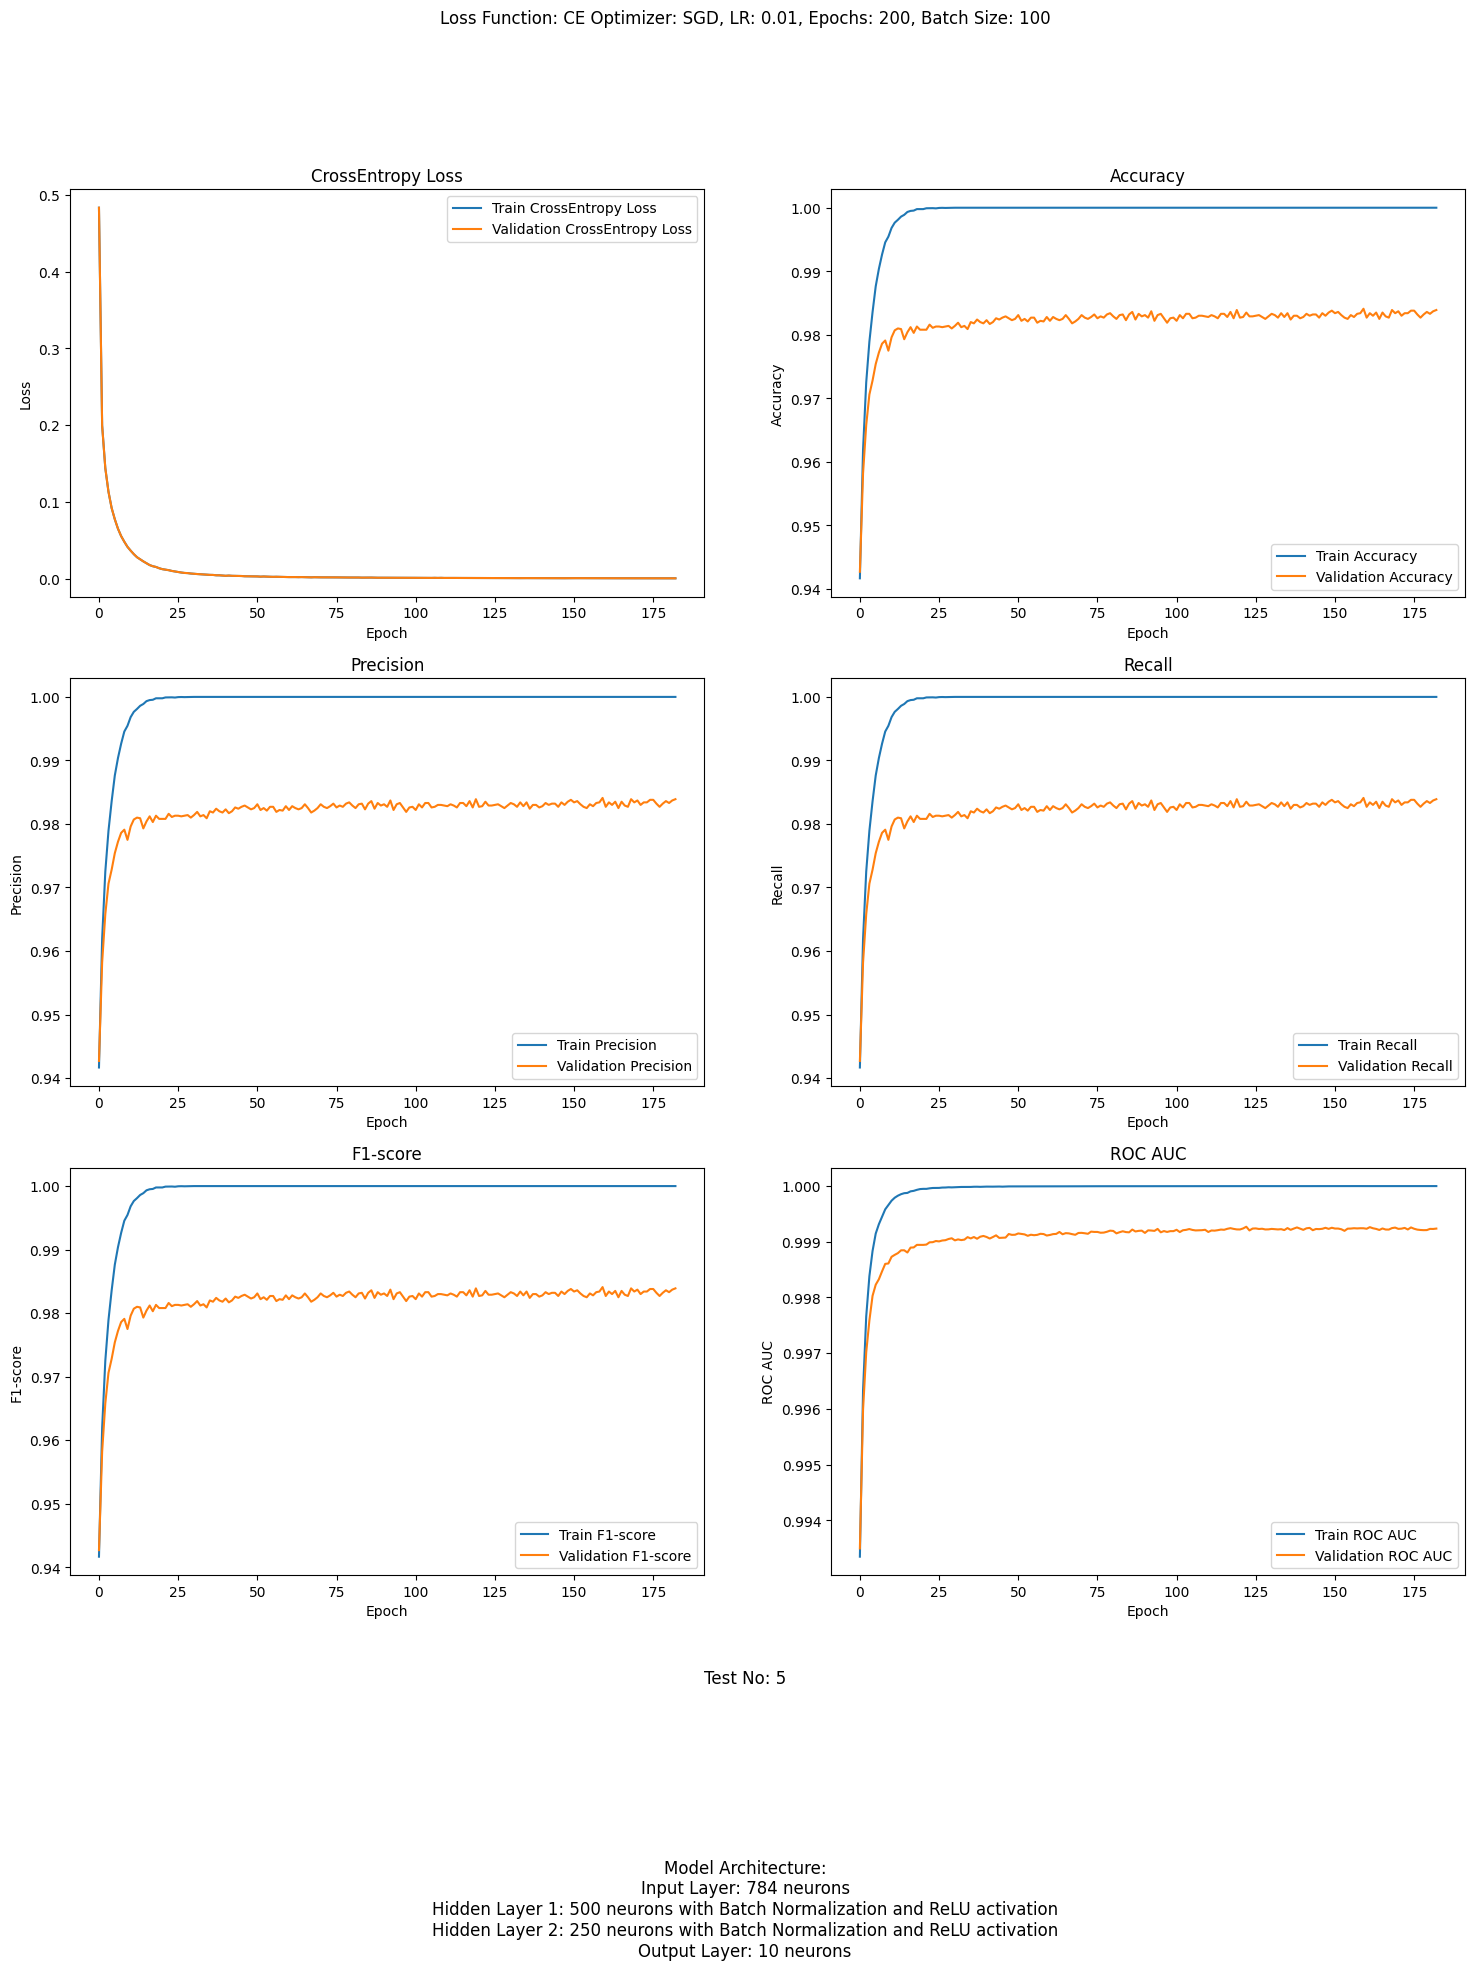

KeyboardInterrupt: 

In [12]:

# Обучение модели
total_step = len(train_loader)
for epoch in range(num_epochs):
    running_loss_ce = 0.0

    for i, (images, labels) in enumerate(train_loader):
        # Ресайз изображений
        images = images.reshape(-1, 28*28)
        
        # Прямой проход
        outputs = model(images)
        # Преобразование данных для каждой функции потерь
        labels_ce = labels
        labels_mse = outputs.clone().detach()
        labels_l1 = outputs.clone().detach()
        
        #loss_l1 = criterion_l1(outputs, labels_l1)
        loss_ce = criterion_ce(outputs, labels_ce)
        #loss_mse = criterion_mse(outputs, labels_mse)



        optimizer.zero_grad()
        loss_ce.backward()
        optimizer.step()
        
        running_loss_ce += loss_ce.item()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss CE: {loss_ce.item():.4f}, ')
    
    # Тестирование модели
    model.eval()
    
    # Метрики для обучающего набора данных
    train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = compute_metrics(train_loader, model)
    # Метрики для валидационного набора данных
    val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = compute_metrics(test_loader, model)
    
    avg_loss_ce = running_loss_ce / total_step
    
    loss_ce_list['train'].append(avg_loss_ce)
    accuracy_list['train'].append(train_accuracy)
    precision_list['train'].append(train_precision)
    recall_list['train'].append(train_recall)
    f1_list['train'].append(train_f1)

    roc_auc_list['train'].append(train_roc_auc)
    
    loss_ce_list['val'].append(avg_loss_ce)
    accuracy_list['val'].append(val_accuracy)
    precision_list['val'].append(val_precision)
    recall_list['val'].append(val_recall)
    f1_list['val'].append(val_f1)

    roc_auc_list['val'].append(val_roc_auc)
    

    
    # Обновление и сохранение графиков
    update_plots(loss_ce_list, accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, epoch)

    model.train()

In [ ]:
# Запись результатов тестов в файл логирования
with open(log_file_path, 'a') as log_file:
    log_file.write(f"{get_test_number(log_file_path)}\t{val_accuracy:.4f}\t{val_precision:.4f}\t{val_recall:.4f}\t{val_f1:.4f}\t{val_roc_auc:.4f}\n")


In [ ]:
# Сохранение финальных графиков
update_plots(loss_ce_list, accuracy_list, precision_list, recall_list, f1_list, roc_auc_list, num_epochs-1, f'results/test_{get_test_number(log_file_path)}.png')

In [ ]:
# Функция для сохранения модели
def save_model(model, test_number):
    model_path = f'models/model_{test_number}.ckpt'
    torch.save(model.state_dict(), model_path)
    return model_path

if save_model:
    test_number = get_test_number(log_file_path)
    model_path = save_model(model, test_number)
    print(f"Model saved as {model_path}")